In [1]:
# Core Libraries
import os
import json
import cv2
import torch
import numpy as np
import pandas as pd

# Torch Modules
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# Vision Transformer
from torchvision import transforms

# Utilities
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def create_splits(data_dir, out_dir, train_p=0.7, val_p=0.15, test_p=0.15, seed=42):
    reals, fakes = [], []

    for folder in ['Celeb-real', 'YouTube-real']:
        path = os.path.join(data_dir, folder)
        reals += [os.path.join(folder, f) for f in os.listdir(path) if f.endswith('.mp4')]

    fake_dir = os.path.join(data_dir, 'Celeb-synthesis')
    fakes = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_dir) if f.endswith('.mp4')]
    fakes = fakes[:2000]  # TEMP LIMIT

    counts = {'real': len(reals), 'fake': len(fakes)}
    print(f"Real: {counts['real']} | Fake: {counts['fake']}")

    splits = {'train': [], 'val': [], 'test': []}

    for clips in [reals, fakes]:
        train, rest = train_test_split(clips, train_size=train_p, random_state=seed)
        val_size = val_p / (val_p + test_p)
        val, test = train_test_split(rest, train_size=val_size, random_state=seed)

        splits['train'] += train
        splits['val'] += val
        splits['test'] += test

    with open(os.path.join(out_dir, 'splits.json'), 'w') as f:
        json.dump({'splits': splits, 'class_counts': counts}, f)

    return splits, counts

In [3]:
class ClipDataset(Dataset):
    def __init__(self, root, split_dir, mode='train', seq_len=10, transform=None):
        self.root = Path(root)
        self.seq_len = seq_len
        self.transform = transform

        with open(os.path.join(split_dir, 'splits.json'), 'r') as f:
            meta = json.load(f)
            self.clips = meta['splits'][mode]
            self.class_counts = meta['class_counts']

    def get_sampler(self):
        weights = []
        max_count = max(self.class_counts.values())

        for path in self.clips:
            label = 'fake' if 'synthesis' in path else 'real'
            weights.append(max_count / self.class_counts[label])

        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

    def __len__(self):
        return len(self.clips)

    def __getitem__(self, idx):
        clip_path = self.clips[idx]
        label = 1 if 'synthesis' in clip_path else 0

        frames = self._load_clip(os.path.join(self.root, clip_path))
        if self.transform:
            frames = torch.stack([self.transform(f) for f in frames])

        return frames, label

    def _load_clip(self, path):
        cap = cv2.VideoCapture(path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, total - 1, self.seq_len, dtype=int)

        frames = []
        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                fallback = frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8)
                frames.append(fallback)
        cap.release()
        return np.stack(frames)

In [4]:
def get_dataloaders(data_root, split_dir, size, batch_size=4, seq_len=10):
    tfm = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    _, stats = create_splits(data_root, split_dir)

    train_set = ClipDataset(data_root, split_dir, 'train', seq_len, tfm)
    val_set = ClipDataset(data_root, split_dir, 'val', seq_len, tfm)
    test_set = ClipDataset(data_root, split_dir, 'test', seq_len, tfm)

    train_loader = DataLoader(train_set, batch_size=batch_size,
                              sampler=train_set.get_sampler(),
                              num_workers=4, pin_memory=True)

    val_loader = DataLoader(val_set, batch_size=batch_size,
                            shuffle=False, num_workers=4, pin_memory=True)

    test_loader = DataLoader(test_set, batch_size=batch_size,
                             shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, stats

In [5]:
train_loader, val_loader, test_loader, class_counts = get_dataloaders(
    data_root='/kaggle/input/celeb-df-v2',
    split_dir='/kaggle/working/',
    size=224,
    batch_size=12,
    seq_len=16
)

Real: 890 | Fake: 2000


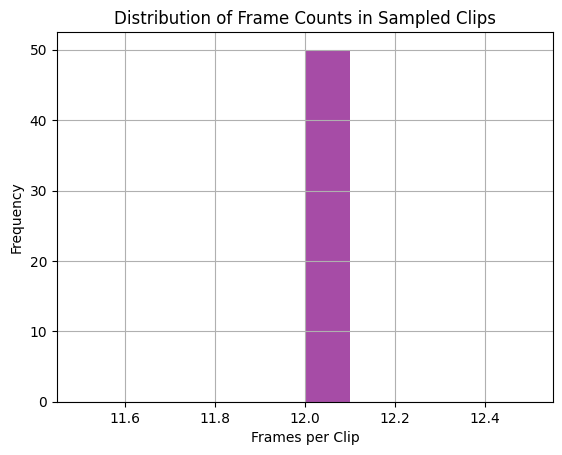

In [6]:
def plot_frame_counts(loader, samples=50):
    frame_counts = []
    for i, (clip, _) in enumerate(loader):
        if i >= samples:
            break
        frame_counts.append(clip.shape[0])
    
    plt.hist(frame_counts, bins=10, color='purple', alpha=0.7)
    plt.title("Distribution of Frame Counts in Sampled Clips")
    plt.xlabel("Frames per Clip")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_frame_counts(train_loader)

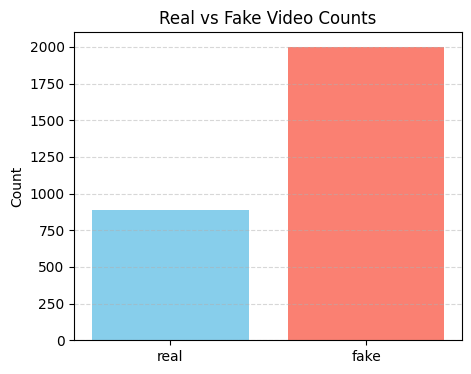

In [7]:
def plot_class_distribution(class_counts):
    labels = list(class_counts.keys())
    values = list(class_counts.values())

    plt.figure(figsize=(5, 4))
    plt.bar(labels, values, color=['skyblue', 'salmon'])
    plt.title("Real vs Fake Video Counts")
    plt.ylabel("Count")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

plot_class_distribution(class_counts)

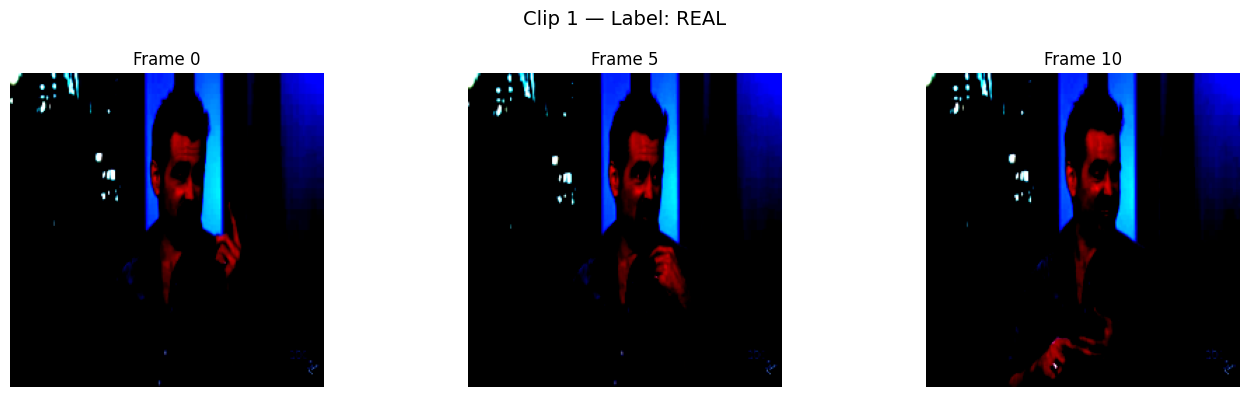

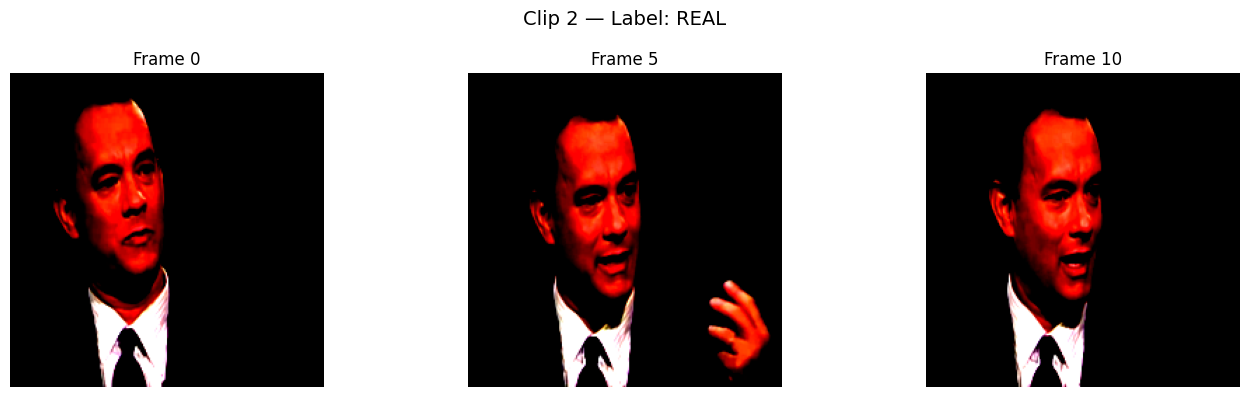

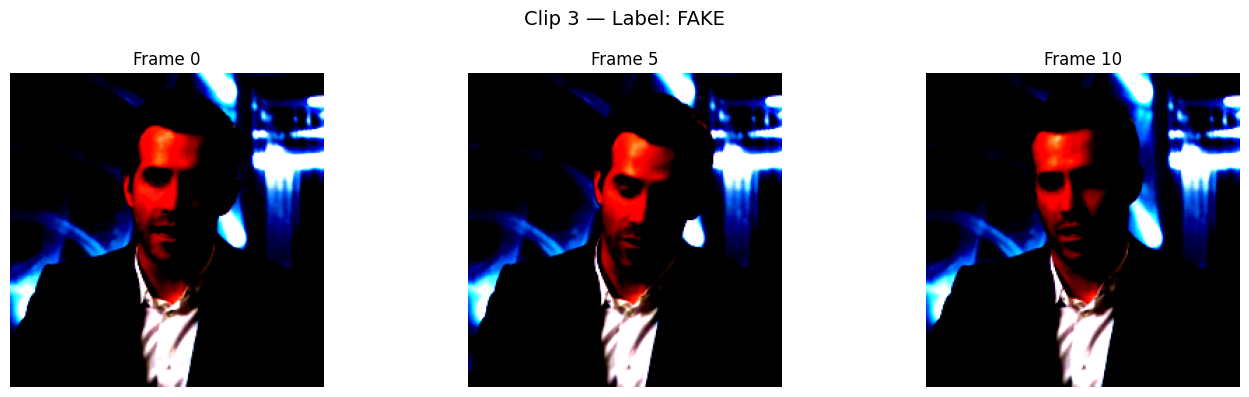

In [8]:
def show_sample_clips(loader, count=3, frames_per_clip=3):
    clips, targets = next(iter(loader))
    clips, targets = clips[:count], targets[:count]

    for i, clip in enumerate(clips):
        clip_np = clip.permute(0, 2, 3, 1).numpy()  # [T, H, W, C]
        fig, axs = plt.subplots(1, frames_per_clip, figsize=(14, 4))
        fig.suptitle(f"Clip {i+1} — Label: {'FAKE' if targets[i] == 1 else 'REAL'}", fontsize=14)

        for j in range(frames_per_clip):
            idx = int(j * len(clip_np) / frames_per_clip)
            axs[j].imshow(clip_np[idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {idx}")

        plt.tight_layout()
        plt.show()

show_sample_clips(train_loader, count=3, frames_per_clip=3)

In [9]:
import torch.nn.functional as F
from torchvision.models.video import mvit_v2_s, MViT_V2_S_Weights
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import wandb

class MViTClassifier(nn.Module):
    def __init__(self, num_classes=1, dropout=0.4):
        super().__init__()
        self.backbone = mvit_v2_s(weights="DEFAULT")

        # Modify final head
        feat_dim = self.backbone.head[1].in_features
        self.backbone.head = nn.Sequential(
            nn.Linear(feat_dim, feat_dim // 2),
            nn.LayerNorm(feat_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(feat_dim // 2, num_classes),
            nn.Sigmoid() if num_classes == 1 else nn.Identity()
        )

    def forward(self, x):
        # x: [B, T, C, H, W] → permute to [B, C, T, H, W]
        x = x.permute(0, 2, 1, 3, 4)
        out = self.backbone(x).squeeze()

        if isinstance(out, torch.Tensor) and out.dim() == 0:
            out = out.unsqueeze(0)

        return out

In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_curve

class DeepfakeTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader,
                 lr=1e-4, wd=0.01, epochs=5, device='cuda', use_wandb=False):
        
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.history = []

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=epochs, eta_min=lr/100)

        if use_wandb:
            self._init_wandb()

    def _init_wandb(self):
        wandb.init(project="deepfake-detector", config={
            "model": self.model.__class__.__name__,
            "epochs": self.epochs,
            "batch_size": self.train_loader.batch_size,
        })

    def _train_epoch(self):
        self.model.train()
        running_loss = 0
        preds, labels = [], []

        loop = tqdm(self.train_loader, desc="Training", leave=False)
        for clips, targets in loop:
            clips = clips.to(self.device)
            targets = targets.to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(clips)
            loss = self.criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            running_loss += loss.item()
            preds.extend(outputs.detach().cpu().numpy())
            labels.extend(targets.cpu().numpy())

        stats = self._compute_metrics(preds, labels)
        stats['loss'] = running_loss / len(self.train_loader)
        return stats

    def _validate(self, loader, mode='val'):
        self.model.eval()
        running_loss = 0
        preds, labels = [], []

        with torch.no_grad():
            for clips, targets in loader:
                clips = clips.to(self.device)
                targets = targets.to(self.device).float()

                outputs = self.model(clips)
                loss = self.criterion(outputs, targets)
                running_loss += loss.item()

                preds.extend(outputs.cpu().numpy())
                labels.extend(targets.cpu().numpy())

        stats = self._compute_metrics(preds, labels)
        if mode == 'val':
            stats['loss'] = running_loss / len(loader)
        return stats

    def _compute_metrics(self, preds, targets):
        preds = np.array(preds)
        targets = np.array(targets)
        bin_preds = (preds > 0.5).astype(int)

        prec, recall, f1, _ = precision_recall_fscore_support(targets, bin_preds, average='binary')
        auc = roc_auc_score(targets, preds)
        acc = accuracy_score(targets, bin_preds)

        fpr, tpr, thresholds = roc_curve(targets, preds)
        fnr = 1 - tpr
        eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
        eer = fpr[np.nanargmin(np.abs(fnr - fpr))]

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'eer': eer
        }

    def train(self):
        best_auc = 0
        patience = 3
        wait = 0

        for epoch in range(1, self.epochs + 1):
            print(f"\n--- Epoch {epoch}/{self.epochs} ---")
            train_stats = self._train_epoch()
            val_stats = self._validate(self.val_loader)

            self.scheduler.step()

            if val_stats['auc'] > best_auc:
                best_auc = val_stats['auc']
                wait = 0
                torch.save(self.model.state_dict(), 'best_model.pth')
                print("New best AUC — model saved.")
            else:
                wait += 1
                if wait >= patience:
                    print("Early stopping triggered.")
                    break

            self._log(epoch, train_stats, val_stats)

        print("\nFinal Evaluation on Test Set")
        print('-' * 60)
        test_stats = self._validate(self.test_loader, mode='test')
        print(test_stats)

    def _log(self, epoch, train_stats, val_stats):
        print(f"Epoch {epoch}:")
        print("Train | " + " | ".join([f"{k}: {v:.4f}" for k, v in train_stats.items()]))
        print("Val   | " + " | ".join([f"{k}: {v:.4f}" for k, v in val_stats.items()]))

        self.history.append({
            'epoch': epoch,
            'train': train_stats,
            'val': val_stats
        })

        if self.use_wandb:
            wandb.log({
                f"{p}_{k}": v
                for p in ['train', 'val']
                for k, v in locals()[f"{p}_stats"].items()
            })

In [11]:
def run_training(train_loader, val_loader, test_loader, cfg=None):
    if cfg is None:
        cfg = {
            'learning_rate': 1e-4,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }

    model = MViTClassifier()
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    trainer_obj = DeepfakeTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        lr=cfg['learning_rate'],
        wd=cfg['weight_decay'],
        epochs=cfg['epochs'],
        device=cfg['device'],
        use_wandb=cfg['use_wandb']
    )

    trainer_obj.train()
    return model, trainer_obj.history

In [12]:
model, metrics_log = run_training(train_loader, val_loader, test_loader)

Downloading: "https://download.pytorch.org/models/mvit_v2_s-ae3be167.pth" to /root/.cache/torch/hub/checkpoints/mvit_v2_s-ae3be167.pth
100%|██████████| 132M/132M [00:00<00:00, 184MB/s]  



--- Epoch 1/10 ---


[✓] New best AUC — model saved.
Epoch 1:
Train | accuracy: 0.6110 | precision: 0.6941 | recall: 0.3865 | f1: 0.4965 | auc: 0.6707 | eer: 0.3729 | loss: 0.6734
Val   | accuracy: 0.7321 | precision: 0.7738 | recall: 0.8667 | f1: 0.8176 | auc: 0.7524 | eer: 0.3308 | loss: 0.5644

--- Epoch 2/10 ---


[✓] New best AUC — model saved.
Epoch 2:
Train | accuracy: 0.7257 | precision: 0.7530 | recall: 0.6736 | f1: 0.7111 | auc: 0.7943 | eer: 0.2626 | loss: 0.6304
Val   | accuracy: 0.6651 | precision: 0.9379 | recall: 0.5533 | f1: 0.6960 | auc: 0.8526 | eer: 0.1955 | loss: 0.5541

--- Epoch 3/10 ---


[✓] New best AUC — model saved.
Epoch 3:
Train | accuracy: 0.8107 | precision: 0.8440 | recall: 0.7750 | f1: 0.8080 | auc: 0.8750 | eer: 0.1831 | loss: 0.5876
Val   | accuracy: 0.7898 | precision: 0.8382 | recall: 0.8633 | f1: 0.8506 | auc: 0.8528 | eer: 0.2256 | loss: 0.5305

--- Epoch 4/10 ---


[✓] New best AUC — model saved.
Epoch 4:
Train | accuracy: 0.7721 | precision: 0.8241 | recall: 0.6576 | f1: 0.7315 | auc: 0.8178 | eer: 0.2331 | loss: 0.6149
Val   | accuracy: 0.7390 | precision: 0.9390 | recall: 0.6667 | f1: 0.7797 | auc: 0.8824 | eer: 0.1880 | loss: 0.5270

--- Epoch 5/10 ---


[✓] New best AUC — model saved.
Epoch 5:
Train | accuracy: 0.8418 | precision: 0.8668 | recall: 0.8087 | f1: 0.8367 | auc: 0.8859 | eer: 0.1615 | loss: 0.5782
Val   | accuracy: 0.7991 | precision: 0.9312 | recall: 0.7667 | f1: 0.8410 | auc: 0.8924 | eer: 0.1654 | loss: 0.5093

--- Epoch 6/10 ---


Epoch 6:
Train | accuracy: 0.8675 | precision: 0.8791 | recall: 0.8531 | f1: 0.8659 | auc: 0.9041 | eer: 0.1338 | loss: 0.5678
Val   | accuracy: 0.8406 | precision: 0.8787 | recall: 0.8933 | f1: 0.8860 | auc: 0.8782 | eer: 0.1654 | loss: 0.5064

--- Epoch 7/10 ---


[✓] New best AUC — model saved.
Epoch 7:
Train | accuracy: 0.8942 | precision: 0.9177 | recall: 0.8716 | f1: 0.8941 | auc: 0.9288 | eer: 0.1054 | loss: 0.5491
Val   | accuracy: 0.8430 | precision: 0.8816 | recall: 0.8933 | f1: 0.8874 | auc: 0.8990 | eer: 0.1579 | loss: 0.5042

--- Epoch 8/10 ---


[✓] New best AUC — model saved.
Epoch 8:
Train | accuracy: 0.9046 | precision: 0.9017 | recall: 0.9079 | f1: 0.9048 | auc: 0.9330 | eer: 0.0967 | loss: 0.5517
Val   | accuracy: 0.8545 | precision: 0.9278 | recall: 0.8567 | f1: 0.8908 | auc: 0.9019 | eer: 0.1504 | loss: 0.4925

--- Epoch 9/10 ---


Epoch 9:
Train | accuracy: 0.9254 | precision: 0.9195 | recall: 0.9348 | f1: 0.9271 | auc: 0.9486 | eer: 0.0763 | loss: 0.5387
Val   | accuracy: 0.8614 | precision: 0.9138 | recall: 0.8833 | f1: 0.8983 | auc: 0.9000 | eer: 0.1504 | loss: 0.4915

--- Epoch 10/10 ---


Epoch 10:
Train | accuracy: 0.9105 | precision: 0.9071 | recall: 0.9062 | f1: 0.9067 | auc: 0.9369 | eer: 0.0864 | loss: 0.5557
Val   | accuracy: 0.8637 | precision: 0.8977 | recall: 0.9067 | f1: 0.9022 | auc: 0.8972 | eer: 0.1429 | loss: 0.4935

[🏁] Final Evaluation on Test Set
------------------------------------------------------------
{'accuracy': 0.7949308755760369, 'precision': 0.8286604361370716, 'recall': 0.8866666666666667, 'f1': 0.856682769726248, 'auc': 0.8296268656716418, 'eer': 0.23134328358208955}


In [22]:
import matplotlib.pyplot as plt

def plot_training_metrics_simple(metrics_log):
    epochs = [entry['epoch'] for entry in metrics_log]
    keys = list(metrics_log[0]['train'].keys())

    for key in keys:
        train_vals = [e['train'][key] for e in metrics_log]
        val_vals = [e['val'][key] for e in metrics_log]

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_vals, label='Train', marker='o')
        plt.plot(epochs, val_vals, label='Validation', marker='o', linestyle='--')
        plt.title(f"{key.upper()} Over Epochs")
        plt.xlabel('Epoch')
        plt.ylabel(key.upper())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

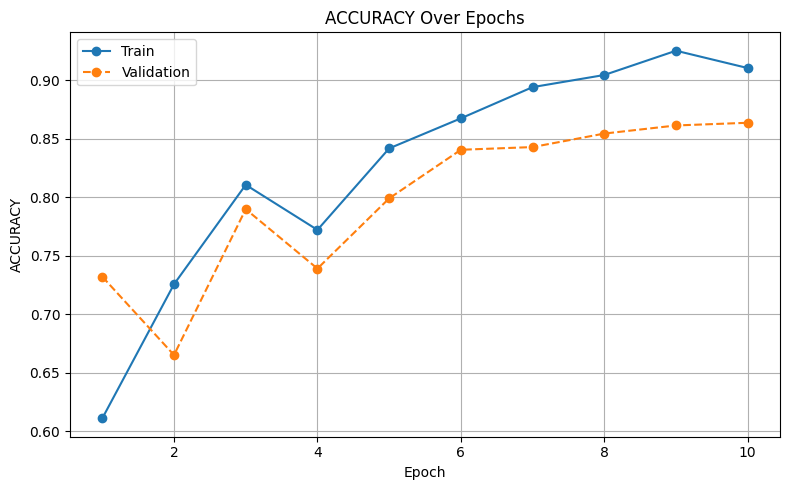

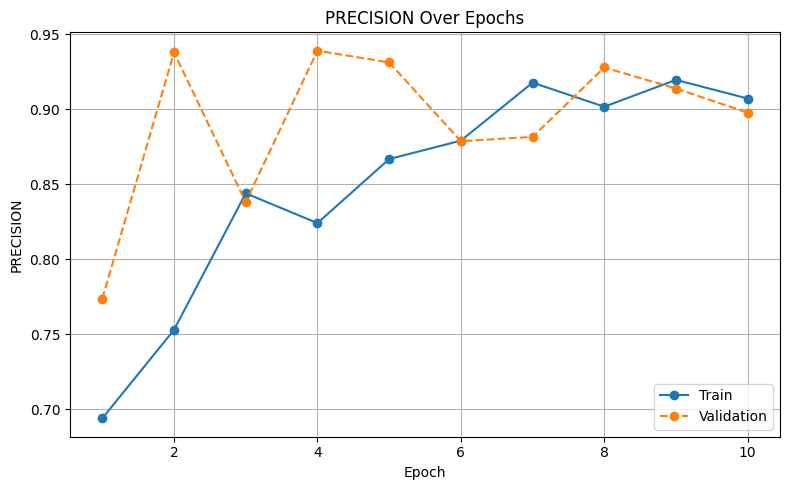

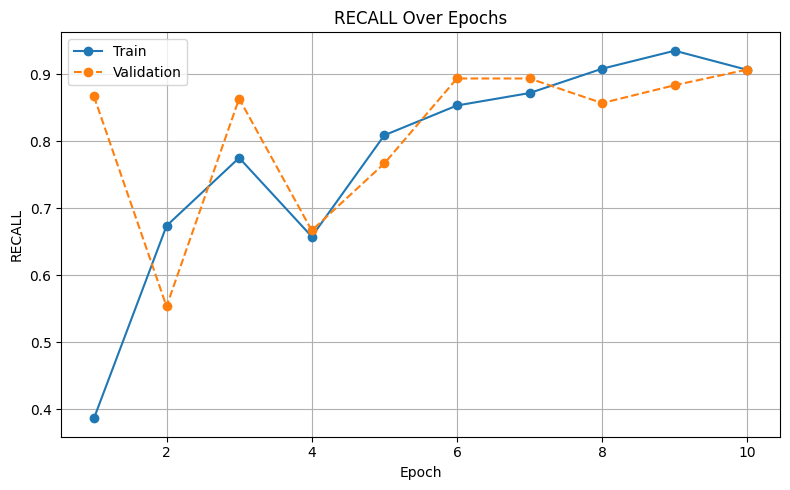

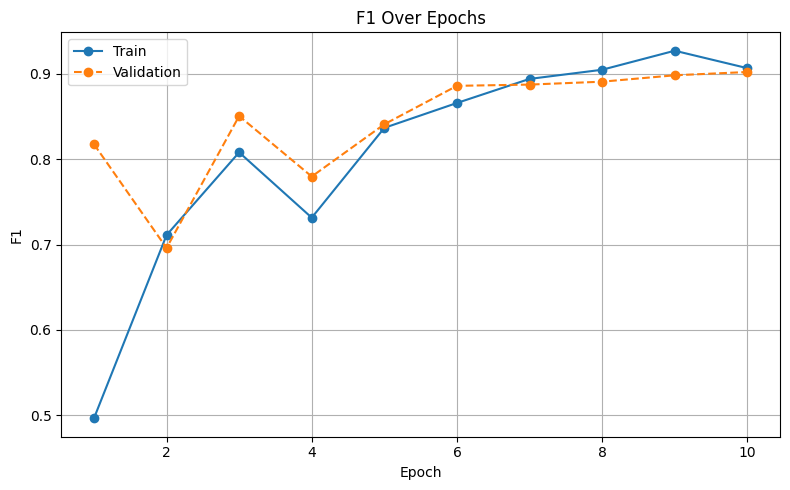

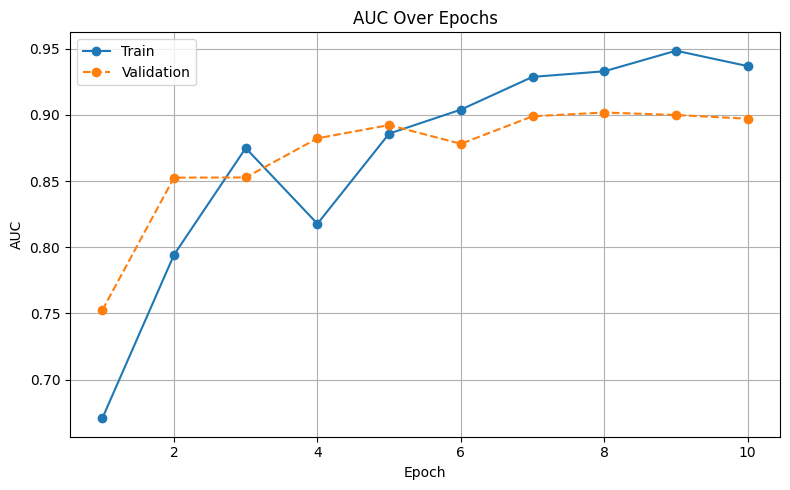

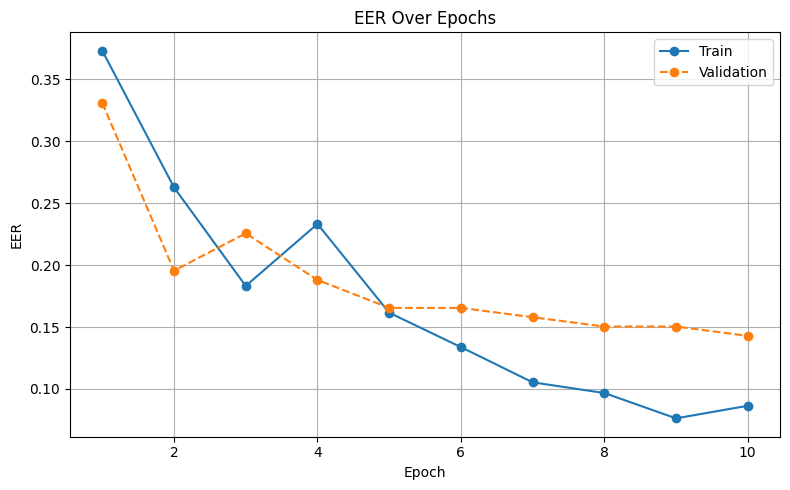

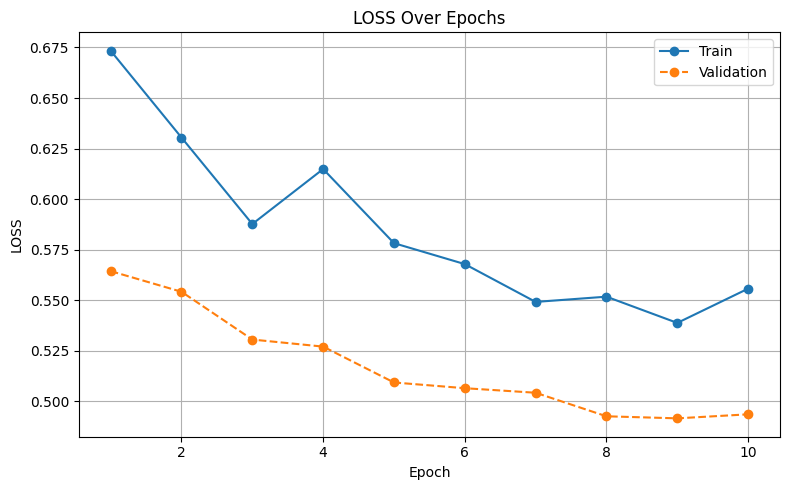

In [23]:
plot_training_metrics_simple(metrics_log)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_fscore_support,
    roc_auc_score,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

class DeepfakeEvaluator:
    def __init__(self, model, loader, device='cuda', labels=None):
        self.model = model.to(device)
        self.loader = loader
        self.device = device
        self.class_names = labels or ['Real', 'Fake']
        self.probs = []
        self.ground_truth = []
        self.frames = []
        self.threshold = 0.59

    def _run_eval(self):
        self.model.eval()
        with torch.no_grad():
            for clips, targets in self.loader:
                clips = clips.to(self.device)
                targets = targets.to(self.device)

                out = self.model(clips)
                p = torch.sigmoid(out).cpu().numpy()
                self.probs.extend(p)
                self.ground_truth.extend(targets.cpu().numpy())
                self.frames.extend(clips.cpu().numpy())

        self.probs = np.array(self.probs).squeeze()
        self.ground_truth = np.array(self.ground_truth).squeeze()
        self.frames = np.array(self.frames)

        return self._compute_scores()

    def _compute_scores(self):
        preds = (self.probs > self.threshold).astype(int)

        prec, rec, f1, _ = precision_recall_fscore_support(
            self.ground_truth, preds, average='binary'
        )
        auc = roc_auc_score(self.ground_truth, self.probs)
        acc = accuracy_score(self.ground_truth, preds)

        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "auc": auc
        }

    def show_confusion(self):
        preds = (self.probs > self.threshold).astype(int)
        cm = confusion_matrix(self.ground_truth, preds)

        disp = ConfusionMatrixDisplay(cm, display_labels=self.class_names)
        disp.plot(cmap="Purples", values_format='d')
        plt.title("Prediction Confusion Matrix")
        plt.grid(False)
        plt.show()

    def show_roc(self):
        fpr, tpr, _ = roc_curve(self.ground_truth, self.probs)
        auc_val = roc_auc_score(self.ground_truth, self.probs)

        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}", color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    def show_examples(self, count=5):
        preds = (self.probs > self.threshold).astype(int)
        mis_idx = np.where(preds != self.ground_truth)[0]
        correct_idx = np.where(preds == self.ground_truth)[0]

        def plot(idx_set, title):
            idxs = np.random.choice(idx_set, min(len(idx_set), count), replace=False)
            fig, axs = plt.subplots(1, len(idxs), figsize=(16, 4))
            fig.suptitle(title, fontsize=16)
            if len(idxs) == 1: axs = [axs]
            for ax, i in zip(axs, idxs):
                img = self.frames[i][0].transpose(1, 2, 0)  # Show first frame, RGB
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"T: {self.class_names[int(self.ground_truth[i])]} | P: {self.class_names[int(preds[i])]}")
            plt.show()

        if len(mis_idx) > 0:
            plot(mis_idx, "Misclassifications")
        else:
            print("No misclassifications found.")

        if len(correct_idx) > 0:
            plot(correct_idx, "Correct Classifications")
        else:
            print("No correct classifications found.")

    def summary(self):
        print("Evaluating on Test Set...")
        stats = self._run_eval()

        print("\nMetrics:")
        for k, v in stats.items():
            print(f"{k.title():<10}: {v:.4f}")

        self.show_confusion()
        self.show_examples()
        self.show_roc()

Evaluating on Test Set...

Metrics:
Accuracy  : 0.7972
Precision : 0.8292
Recall    : 0.8900
F1        : 0.8585
Auc       : 0.8296


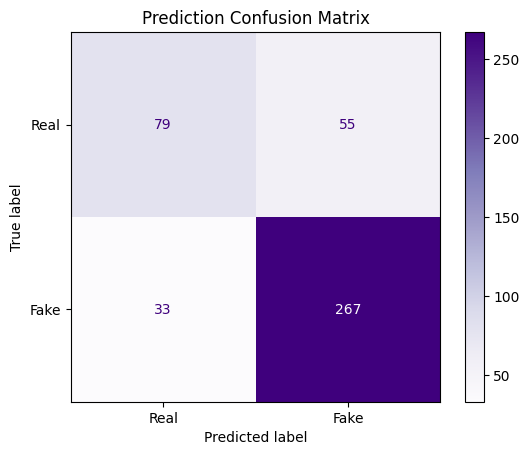

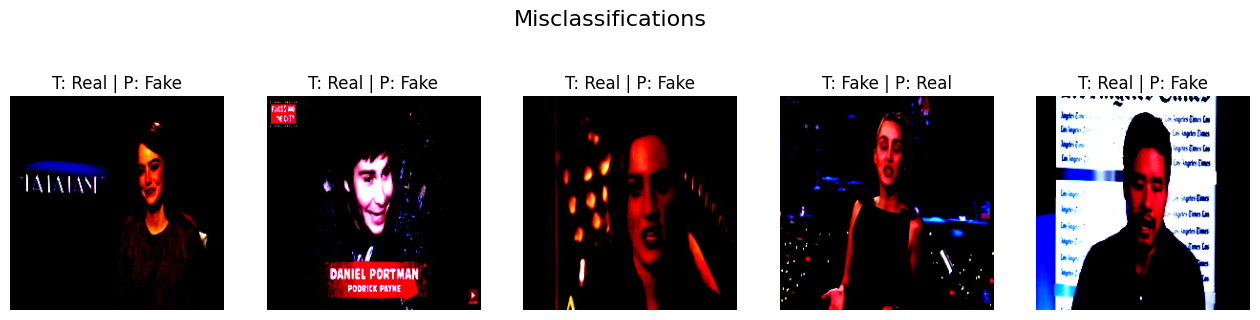

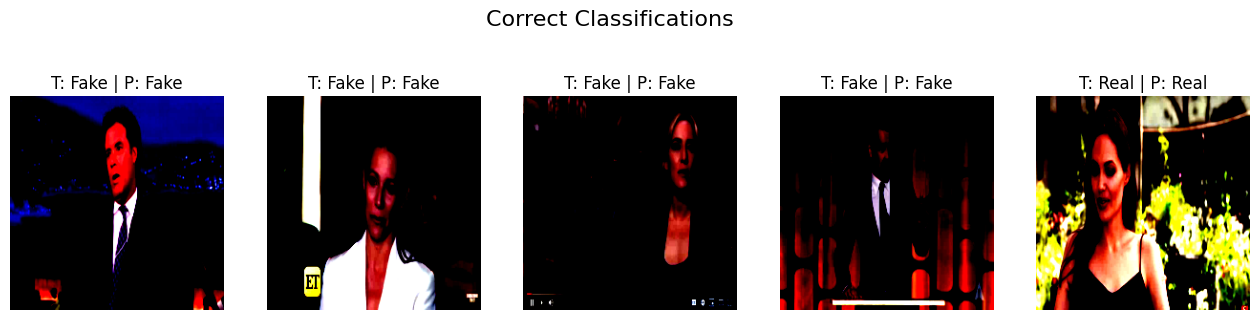

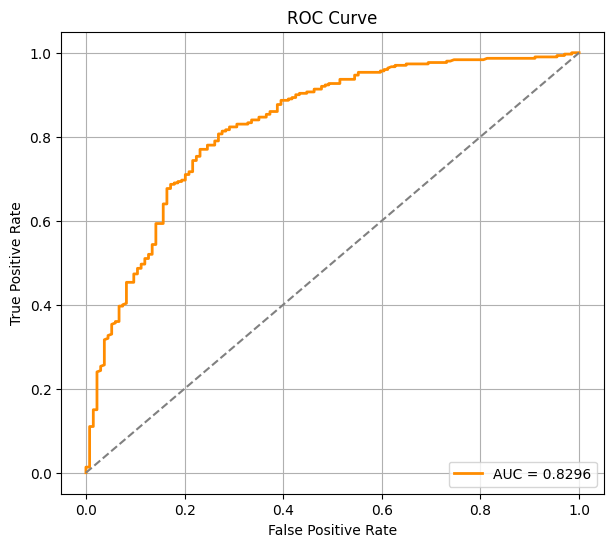

In [15]:
evaluator = DeepfakeEvaluator(model, test_loader, device='cuda')
evaluator.summary()